In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data() :
    df = pd.read_csv('t_data.csv')
    print("Features=",df.columns)
    print("Num Years=",len(df)//12,"Num Months=",len(df))
    df['month'] = df.index
    return df[0:150*12],df[150*12:]

def make_features(df,periods) :
    names = ['ones','t']
    df['ones'] = 1
    df['t'] = df.month
    for p in periods :
        c_s,s_s = 'cos(2pi*t/%d)'%p,'sin(2pi*t/%d)'%p,
        names.append(c_s)
        names.append(s_s)
        df[c_s],df[s_s] = np.cos(2*np.pi*df.month/p),np.sin(2*np.pi*df.month/p)
    return df[names],df['max_temp_C']

def plot_coefficients(b,train_X) :
    names = train_X.columns.values
    df = pd.DataFrame({'names':names,'values':b})
    print(df)
    plt.stem(range(len(b)),b)
    plt.xticks(range(len(b)),names,rotation=90)
    plt.savefig('coeff_stem.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    print(df.iloc[1,0],df.iloc[1,1]*12*100)

def plot_fit(X,y,b,name) :
    plt.plot(X.t,y,label='Actual')
    plt.plot(X.t,X@b,label='Predicted')
    plt.xlabel('Month')
    plt.ylabel('Max Temperature (C)')
    plt.title('Max Temperature - '+name)
    plt.legend()
    plt.savefig('%s_fit.pdf'%name,bbox_inches='tight')
    plt.show()
    plt.close()
    print('%s RMS Error'%name,np.sqrt((np.linalg.norm(X@b-y)**2)/len(X)))
    
def RMSError(X, y, b):
    return np.sqrt((np.linalg.norm(X@b-y)**2)/len(X))

## (a)

We have four parameters in the model and $1800$ data points to fit the model. The model is very unlikely to overfit.

## (b)

In [3]:
all_periods = np.arange(1, 21, 1)

In [4]:
train,test = load_data()

Features= Index(['date', 'max_temp_C', 'min_temp_C', 'rain_mm'], dtype='object')
Num Years= 162 Num Months= 1944


In [5]:
coeff_dict = {}
train_error = [None]*len(all_periods)
test_error = [None]*len(all_periods)

In [6]:
for period in all_periods:
    train_X,train_y = make_features(train, [period] )
    test_X,test_y = make_features(test,[period])
    coeff_dict[period],_,_,_ = np.linalg.lstsq(train_X,train_y,rcond=None)
    
    train_error[period-1] = RMSError(train_X, train_y, coeff_dict[period])
    test_error[period-1] = RMSError(test_X, test_y, coeff_dict[period])

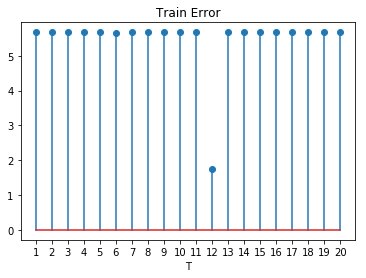

In [7]:
plt.stem(all_periods, train_error)
_ = plt.xticks(ticks = all_periods, labels = all_periods)
_ = plt.title('Train Error')
_ = plt.xlabel('T')
plt.savefig('train_error.pdf',bbox_inches='tight')

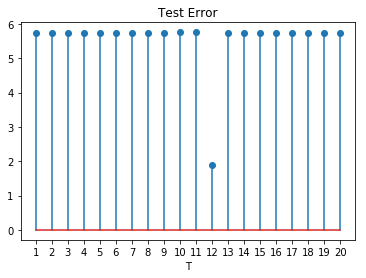

In [8]:
plt.stem(all_periods, test_error)
_ = plt.xticks(ticks = all_periods, labels = all_periods)
_ = plt.title('Test Error')
_ = plt.xlabel('T')
plt.savefig('test_error.pdf',bbox_inches='tight')

$T^* = 12 $. This is not surprising, since we expect weather to be cyclical with a 12 month period.

In [9]:
best_T = 12

## (c)

In [10]:
train_X,train_y = make_features(train, [best_T] )
test_X,test_y = make_features(test,[best_T])

In [11]:
train_X.t

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
11        11
12        12
13        13
14        14
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
28        28
29        29
        ... 
1770    1770
1771    1771
1772    1772
1773    1773
1774    1774
1775    1775
1776    1776
1777    1777
1778    1778
1779    1779
1780    1780
1781    1781
1782    1782
1783    1783
1784    1784
1785    1785
1786    1786
1787    1787
1788    1788
1789    1789
1790    1790
1791    1791
1792    1792
1793    1793
1794    1794
1795    1795
1796    1796
1797    1797
1798    1798
1799    1799
Name: t, Length: 1800, dtype: int64

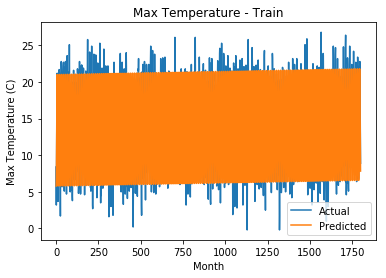

Train RMS Error 1.7500856407936187


In [11]:
plot_fit(train_X, train_y, coeff_dict[best_T],  'Train')

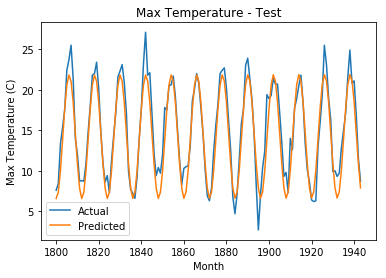

Test RMS Error 1.876330849379237


In [12]:
plot_fit(test_X, test_y, coeff_dict[best_T],  'Test')

## (d)

In [13]:
mod_train_X = train_X.drop(columns = ['cos(2pi*t/12)'])
mod_test_X = test_X.drop(columns  = ['cos(2pi*t/12)'])

In [14]:
mod_coeff, _ , _,  _ = np.linalg.lstsq(mod_train_X,train_y,rcond=None)
    
mod_train_error = RMSError(mod_train_X, train_y, mod_coeff)
mod_test_error = RMSError(mod_test_X, test_y, mod_coeff)

print('Train: mod: ', mod_train_error, ' full: ', train_error[best_T - 1])
print('Test mod: ', mod_test_error, ' full: ', test_error[best_T - 1])

Train: mod:  5.6651334453013815  full:  1.7500856407936187
Test mod:  5.733588444483075  full:  1.876330849379237


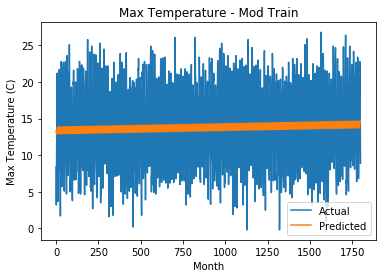

Mod Train RMS Error 5.6651334453013815


In [15]:
plot_fit(mod_train_X, train_y, mod_coeff,  'Mod Train')

The phases don't align when you only include the sin() term. You need the cos() term as well so that you can fit any phase. 

## (d)

           names     values
0           ones  13.406514
1              t   0.000435
2  cos(2pi*t/12)  -7.619841
3  sin(2pi*t/12)  -0.483643


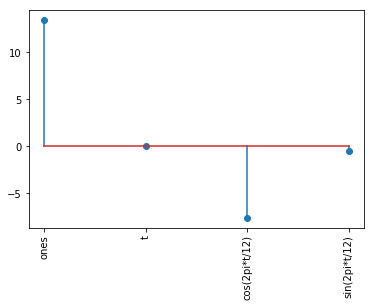

t 0.5225682100119325


In [16]:
plot_coefficients(coeff_dict[best_T], train_X)

ones - account for the bias term

t - captures any linear trend we have in the data

the cos and sin term together accounts for periodic trend in data. 

on combining $c_1 cos(t) + c_2 sin(t) $ one can create $ c \  cos(t + \theta)$ which models a sinusoid with arbitrary phase. 